# 0. Convolutional Networks from Scratch | Mathematics and Python Code
Taken from the Independent Code Channel
[Convolutional NeuralNetworks from Scratch](https://www.youtube.com/watch?v=Lakz2MoHy6o)

This video series recreates several neural networks and codes them out using only python and numpy in Tensorflow/Keras similiar style. From a PyTorch perspective, it creates a nn.Module base class (without the automation) and reproduces Activation functions, loss functions along with back-propagation and gradient descent.

In this book, we will be using what was showed in book 1 to create a CNN from python and numpy using the base classes created in the
The goal of this book is:
1. Convolution operation
2. Convolutional Layer
3. Reshape Layer
4. Binary Cross Entropy Loss
5. Sigmoid activation
6. Solving MNIST

In [1]:
# define all our imports here
import numpy as np

## 1. Convolution operation

Most of this mat theory on how it functions are not  easily reproducable here.
He does a great job using Manin from 3Blue1Brown

Given a 2 dimensional input Matrix (usually square) of dim N,N and a smaller 2d kernel of dim (m,m).

There are 3 parameters that will needed to be defined that will be used later:
1. Kernel size (x,y)  # the size of the sliding window over the input
2. padding # additional zero-filled rows and columns allows extracting features from edges
3. stride # the step size across and down

   All the above paramters play a roll in determining the size of the output matrix
The kernel slides across the input matrix and a dot product is calculate.
At each stopping position the dot product of overlapping cells will fill in one position in the output matrix.

*Example*  we have in this case  for our input (3,3)
* kernel_size = (2,2)
* padding = 0  The outer offset of the kernel start and end positions
* stride  = 1   we step 1 cell right till the end and 1 cell down, then right...
  
input    kernel 

1 6 2 |  1 2

5 3 1 |  -1 0

7 0 4

Now the kernel starts aligning its top left corner with the top left corner of the input.

1 6  1 2......... the dot product is 1*1 + 6*2 + 5*(-1) + 3*0  

5 3  -1 0 ....... = 1 + 12 - 5 = 8 

This ends up in the output     8, ?

...............................?, ?

Kernel slides to the second position overlapping 6 2 and 3,1.
The dot product yields 6*1 + 2*2 + 3*(-1) + 1*0  = 6 + 4 - 3  + 0 = 7   this goes into the next cell.  
The output looks like  

8, 7

?, ?


we are at the end of the row so we perform a 'carrage return' of the kernel stepping down `stride` cells and back to the left edge. THen we continue this row in the same manner

The resulting output matrix is  

8, 7

4, 5       

There is a kernel for depth size of the input  all doing the same so here we get a d,2,2 output shape. Each 2D matrix will be in the shape depending on padding and stride, how many time it can step right and how many times it can step left.

for 0 padding and stride of 1 the output size is:

**Y-K+1**

There is a complex formula for figuring this out, so the easiest way is run the forward pass up to the output layer (usually Dense). Then check the shape and this will be the input shape we need for the next layer

**Note:**  some implementations may have a virtual kernel (mearly a window) and just takes the highest value within the window. This is how most image apps 'shrink the original' keeping as much detail as possible. In any case, we will do the dot product for this book

### 1.1 Is this convolution?
No!  what we did above is called **Cross-correlation**
To do Convolution we need to rotate the kernel 180 degrees
so when the kernel is rotated, the out matrix would be:

7, 5

11, 3

To summarize:
1. Cross correlation Corr(I,K) = I ° K.  The real symbol  is a star
2. Convolution Conv(I,K) = I ° rot180(K).    The real symbol is asterix 

## 1,2 Difference between 'valid' and 'full'

This is where the padding and stride come in

* **valid:**  is described above where the kernel starts with the top left corner aligning with the top left  and ending when bottom rights of kernel and input align   This is equal to `padding` = 0 and `stride` = 1

* **full:**    The symbol is a star with full written bebeath it. In this mode, the bottom right of the kernel aligns with top left on input and ends when top left of kernel aligns with bottom right of the input.  In other words, the kernel starts outside of the input and whenever there is a intersection of `I` and `K` the conv/corr will occur. The non overlapping cells have an assumed value of 0.  This additional "padding" makes `I` larger which is where the calculation gets difficult.  In effect, it is as if the padding of `K`dim - 1 was given. In our case, the `padding` would be = 1 which makes our 3x3 matrix grow to 5x5.

  Each dimension of `I` grows by 2*(`K`dim -1)  or 2X `padding`

## 2. Convolutional Layer
The convolution layer takes as input a 3 dimensional block matrix
The 1st dimension `d` is the depth of x,y input matricies. We'll call these 2D vectore **"Images"** because they usually are where the dims are the height and width of the image.  This example is als0 using a depth of 3, because of RGB color channels. So a 64X64 color image could be converted into a (3,64,64) shaped numpy array.  The number of kernels is also multiplied by the depth and each one has their own learnable weights.  There also could be multiple kernel layer  each extending the full depth of their respective inputs. Each kernel layer also has an ascociated bias  of same dimension as the kernel, also with learnable parameters. THe resulting output depth will be the same as the number of kernel layers. The **HxW** dimensions will vary, depending on the parameters defining the kernel layer

### 2.1 Reducing the granularity
To simplify the notation   we will consider each block to be a black box Matrix of some pre-determined size. Therefore: 

* Inputs of depth D are designated X1, X2, ... , Xd
* Multiple kernel layer Kn :
  
    K11, K12, K13, ..., K1n
  
    K21, K22, K23, ..., K2n
  .
  
  .

  .
    
    Kn1, Kn2, Kn3, ..., Knd

* Output Ý1, Y1, Yn each of these represents  a kernel layer1..n

### 2.2 Deriving the calculation  Creating the forward propagation
The formula can be expressed as follows:

Y1 = B1 + X1°K11 + X2°K12 + . . .+ Xn°K1n

Y2 = B2 + X1°K21 + X2°K22 + . . .+ Xn°K2n

.

Yd = Bd + X1°Kd1 + X2°Kd2 + . . .+ Xn°Kdn

The Basic formula is:

Yi = Bi + Epsilon(j=1..n)Xj star Kij, i = 1...d

All of the above can be defined in a single bloc called a convolutional block,  THere can be many of these blocks within a network model

[Here](https://www.youtube.com/watch?v=Lakz2MoHy6o&t=466) He goes thru the equation manipulation description where the end equation ends up
Y = B + K (dotstar) X   which looks like the same equation for the Dense layer
But since the  input elements X, are matricies and not scalars, he made up this imaginary dotstar symbol, But he goes on to say that if the matricies where dimension 1,1, then it would be a simple dot product and thus identical to the formula used in the forward function of the Dense layer.

The import signal  from scipy can be found [Here](https://docs.scipy.org/doc/scipy/reference/signal.html).  Lost of cool stuff including the correlation and convolve methods.

In [2]:
import numpy as np
from layer import Layer
from scipy import signal
# Note: below he defines the output shape as the easy formula which is 
#       highly dependent on "valid" passed to the correlation function

class Convolution(Layer):
    def __init__(self, input_shape, kernel_size, depth):
        input_depth, input_height, input_width = input_shape
        self.depth = depth
        self.input_shape = input_shape
        self.input_depth = input_depth
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)
        self.kernels = np.random.randn(*self.kernels_shape)
        self.biases  = np.random.randn(*self.output_shape)

    def forward(self, input):
        self.input = input
        self.output = np.copy(self.biases)
        for i in range(self.depth): # output depth
            for j in range(self.input_depth): # input depth
                # warning the correlation is not communative... orders matter!!! X star K
                self.output[i] += signal.correlation2d(self.input[j], self.kernels[i,j], "valid")
        return self.output

    def backward(self, output_gradient, learning_rate):
         # TODO: update parameters and return input gradient
         pass

### 2.3 Creating the backward gradient decent function
The description is [Here](https://www.youtube.com/watch?v=Lakz2MoHy6o&t=784).
A hefty description of creating the partial derivatives:

* pE/pY is the Calculated loss function value we'll call L

* pE/pK = Xj star L  (cross correlation between input and output_gradient)

* pE/pBi  = Li

pE/pX  As with the dense layer, the result is quite interesting. First we are going to a kernel size output_ gradient (2x2) to an input_sized input gradient (3x3).  9 partial derivatives each having a different number of elements in the equation. In this case it is doing a "full" correlation (padding=1).  Additionally looking close at the kernel entries when expanded to all pE_Xi.. we see the K entries are reversed to that of a correlation. Simply put, the kernel is rotated 180 degrees which makes this a 'full' convolution. So going from simple form to actual form of the forward function:

* pE/pXj = Epsilon[i=1..n] (Li full asterix Kij)  where full asterix = convolution

Let's add the backward method and write this to a file

In [3]:
import numpy as np
from layer import Layer
from scipy import signal
# Note: below he defines the output shape as the easy formula which is 
#       highly dependent on "valid" passed to the correlation function

class Convolution(Layer):
    def __init__(self, input_shape, kernel_size, depth):
        input_depth, input_height, input_width = input_shape
        self.depth = depth
        self.input_shape = input_shape
        self.input_depth = input_depth
        self.output_shape = (depth, 
                             input_height - kernel_size + 1, 
                             input_width - kernel_size + 1)
        self.kernels_shape = (depth, 
                              input_depth, 
                              kernel_size, 
                              kernel_size)
        self.kernels = np.random.randn(*self.kernels_shape)
        self.biases  = np.random.randn(*self.output_shape)

    def forward(self, input):
        self.input = input
        self.output = np.copy(self.biases)
        for i in range(self.depth): # output depth
            for j in range(self.input_depth): # input depth
                # warning the correlation is not communative... orders matter!!! X star K
                self.output[i] += signal.correlation2d(self.input[j], 
                                                       self.kernels[i,j], "valid")
        return self.output

    def backward(self, output_gradient, learning_rate):
        kernel_gradient = np.zeros(self.kernels.shape)
        input_gradient = np.zeros(self.input_shape)

        for i in range(self.depth):
            for j in range(self.input_depth):
                kernel_gradient[i, j] = signal.correlation2d(self.input[j],
                                                             output_gradient[i], "valid")
                input_gradient[j] += signal.convolve2d(output_gradient[i], 
                                                       self.kernels[i,j], "full")

        self.kernels -= learning_rate * kernel_gradient
        self.biases -= learning_rate * output_gradient
        return input_gradient           
        

## 3. Reshape Layer  better know as the Flatten activation function in torch

film at 27,20

In [4]:
import numpy as np
from layer import Layer

class Reshape(Layer):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, input):
        return np.reshape(input, self.output_shape)

    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient, self.input_shape)

## 4. Binary Cross Entropy Loss

Binary Cross Entropy is a loss function used in binary classification models ... when the output of the model is either one thing or another. Multiclass classification models use a Cross Entropy loss where there can be more than two classes. The model output layer usually has the shape of num_classes and by using the `sigmoid` function which calculates the probabilities of the input being  a certain class. The sum of the probabilities always eaquls 1 as is usual with all statistics. Using `argmax`, we can get the index of the vector with the highest probability and use this as our best guess prediction.

Given a vector Y* containing the desired output of the neural network. Since we will be making a binary classification, each element in the vector must be either a zer of a 1

$Y_i'$ **∈** {0,1}  # y prime sub i, is a member of the following set {0,1}

The target vector has the same shape and contains the representaton of the label

The formula to compute the loss is:

$$
E = \frac{-1}{n} \sum^n_{i=1} (Y_i' \cdot log(y_i) + (1-Y_i')\cdot log(1-Y_i))
$$   
Be aware of the prime and non prime Yi. Additionally this (1/n) (sum of somethings)  is basically the Average mean

* Y' = y_true, and $Y_i$ = y_pred

The goal is to compute pE/pYi  

##### This is the loss_gradient(see video)

$$
\frac{\partial E}{\partial Y_i'}  = \frac{1}{n} \cdot (\frac{1-Y_i'}{1-Y_i} - \frac{Y_i'}{Y_i})
$$


In [5]:
import numpy as py
# Note that y_true and y_pred are vectors and not scalars
# Although y_true is know as a label, a unique index value  0 .. num_classes

""" I use redundant () in the function for clarity """

# E = (-1/n)Epsilon[i=1..n] (Y*i log(yi) + (1-Y*i)log(1-Yi))
def binary_cross_entropy(y_true, y_pred):
    # notice the log(y_pred) and the log(1 - y_pred)
    # neither of these can be negative since log(-num)  is illegal
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

# pE/pYi = (1/n)((1-Y*i)/(1-Yi) - (Y*i/Yi)) 
def binary_cross_entropy_prime(y_true, y_pred):
    return ( ((1 - y_true) / (1 - y_pred)) - (y_true / y_pred))

## 5. Sigmoid activation

The sigmoid function is defined as:

$$
\sigma(x) =  \frac{1}{1+ e^{-x}} 
$$

Which bounds all the values in `X` nonlinearly into  a  0..1 scale. It resembles the Tanh function shifted up

The derivative can be defined by the sigmoid itself

$$
\sigma'(x) = \frac{e^{-x}}{(1 + e^{-x})^2}  = \sigma(x)\cdot (1- \sigma(x))
$$

In [6]:
import numpy as np
from activations import Activation

class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def sigmoid_prime(x):
            s = sigmoid(x)
            return s * (1-s)

        super().__init__(sigmoid, sigmoid_prime)
        

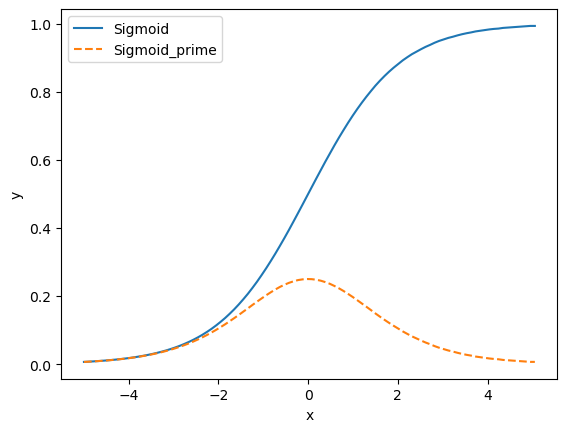

In [7]:
# PLOT the sigmoid and sigmoid_prime functions
import numpy as np
import matplotlib.pyplot as plt
from activations import Sigmoid

x = np.arange(-5,5,0.1,dtype= np.float16)

sig = Sigmoid()
y_sig = sig.activation(x)
y_sig_prime = sig.activation_prime(x)

plt.plot(x,y_sig,label="Sigmoid")
plt.plot(x,y_sig_prime, label = "Sigmoid_prime", linestyle='--')

# Adding labels and legend
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

# Show the plot
plt.show()

## 6. Solving MNIST
This is at 30:45 in the video 
It includes a preprocess function to strip out all the 1's and 0's for speed purposes
since this code is not optimized for a GPU.  Additionally, I believe the Binary Cross Entropy  Loss functions are more easier than their Multi-claas counterparts, as well s faster.

A great excercise would be to try to implement the CrossEntropy and CrossEntropy_prime function, twiddle with the model a bit and see if I can get the thing fully working.  

**MY CHALLENGE TO MYSELF!!!**

Also, I could try porting it to PyTorch since he uses keras but I might someday try to do TensorFlow since that is the tool used in GPT2 and other production grade projects. NVIDIA seems to use both.

Anyway... on to it. Let's get coding!!!

In [8]:
# standard import stuff
import numpy as np
from keras.datasets import mnist
from keras.utils import to_categorical

# some visualization stuff
import matplotlib.pyplot as plt
import pandas as pd

In [9]:

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = np.equal(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


In [10]:
# function to reduce the MNIST data set to just the one and zero data images
# we will be loading the black and white hand-written digits
def preprocess_data(x, y, limit):
    """
    params:
        x  the image data array
        y: the target labels
        limit: limit the size of the dataset
    """
    # leaving the datasets intact, just create index array of all the elements we want
    zero_index = np.where(y == 0)[0][:limit]
    one_index = np.where(y == 1)[0][:limit]
    # stack the arrays and shuffle them

    # do I need repeatability with a manual seed?
    np.random.seed(42)
    all_indices = np.hstack((zero_index, one_index))  # video has 2 sets of () because it is a single tuple param
    all_indices = np.random.permutation(all_indices)

    #Extract only the images we want and do some reshaping
    x, y = x[all_indices], y[all_indices]
    # print (x.shape)
    x = x.reshape(len(x), 1, 28, 28)   # what was the shape before? B,28,28
    #print (x.shape)
    x = x.astype("float32") / 255   # what did it look like?  was integers
    #print (x.shape)

    #print (y.shape,y[0]) one scalar per image
    y = to_categorical(y) # takes the scalar and makes a vector num_classes long with a 1 in the right inx pos
    #print (y.shape,y[0])
    y = y.reshape(len(y), 2, 1) 
    #print (y.shape,y[0])
    return x,y


In [11]:
# function to reduce the MNIST data set to just the one and zero data images
# we will be loading the black and white hand-written digits

"""
The original function was hardcoded for 2 (0 and 1) classes. 
The attempt is to pass in the number of classes I want and hope
I get the right size back
"""

def preprocess_multiclass_data(x, y, limit, num_classes=2):
    """
    params:
        x  the image data array
        y: the target labels
        limit: limit the size of the dataset
    """
    all_indices = []
    for i in range(num_classes):
        idx_arry =  np.where(y == i)[0][:limit]
        all_indices.append(idx_arry)

    # Stack all indices into a single array
    all_indices = np.concatenate(all_indices)

    #print (all_indices[:10])

    # leaving the datasets intact, just create index array of all the elements we want
    #zero_index = np.where(y == 0)[0][:limit]
    #one_index = np.where(y == 1)[0][:limit]
    # stack the arrays and shuffle them

    # do I need repeatability with a manual seed?
    np.random.seed(42)
    #all_indices = np.hstack((zero_index, one_index))  # video has 2 sets of () because it is a single tuple param
    all_indices = np.random.permutation(all_indices)

    #Extract only the images we want and do some reshaping
    x, y = x[all_indices], y[all_indices]
    # print (x.shape)
    x = x.reshape(len(x), 1, 28, 28)   # what was the shape before? B,28,28
    #print (x.shape)
    x = x.astype("float32") / 255   # what did it look like?  was integers
    #print (x.shape)

    #print (y.shape,y[0]) one scalar per image
    y = to_categorical(y) # takes the scalar and makes a vector num_classes long with a 1 in the right inx pos
    print (y.shape,y[0])
    y = y.reshape(len(y), num_classes, 1) 
    print (y.shape,y[0])
    return x,y


In [12]:
# load MNIST from server and limit to 100 images per class since we are not running on a gpu
(x_train_dataset, y_train_dataset), (x_test_dataset, y_test_dataset) = mnist.load_data()
x_train, y_train = preprocess_multiclass_data(x_train_dataset, y_train_dataset,100)
x_test, y_test = preprocess_multiclass_data(x_test_dataset, y_test_dataset,100)


(200, 2) [1. 0.]
(200, 2, 1) [[1.]
 [0.]]
(200, 2) [1. 0.]
(200, 2, 1) [[1.]
 [0.]]


In [13]:
# model from scratch specific imports
from dense import Dense
from convolutional import Convolutional
from reshape import Reshape
from activations import Tanh, Sigmoid
from losses import binary_cross_entropy, binary_cross_entropy_prime

In [14]:
# Create the model
network = [
    Convolutional((1,28,28),kernel_size=3,depth=5),
    Sigmoid(),
    Reshape(input_shape=(5,26,26),
            output_shape=(5*26*26,1)),  # column-wise Flattened
    Dense(input_size=(5*26*26),output_size=100),
    Sigmoid(),
    Dense(100,2),
    Sigmoid()
]

In [15]:
# Training loop
epochs = 20
learning_rate = 0.01
for epoch in range(epochs):
    error = 0    # optimizer.zero_grad
    for x,y in zip(x_train, y_train):  #for image in batch
        # forward pass
        output = x
        for layer in network:
            output = layer.forward(output)
        #print (output)

        # calculate the loss
        error += binary_cross_entropy(y_true=y, y_pred=output)
        # backward
        grad = binary_cross_entropy_prime(y_true=y, y_pred=output)
        #grad = grad[0]
        for layer in reversed(network):
            grad = layer.backward(grad, learning_rate)

    error /= len(x_train)
    print(f"Epoch: {epoch}/{epochs}, error = {error:.4f}")

Epoch: 0/20, error = 0.7093
Epoch: 1/20, error = 0.3258
Epoch: 2/20, error = 0.2340
Epoch: 3/20, error = 0.1592
Epoch: 4/20, error = 0.1274
Epoch: 5/20, error = 0.1048
Epoch: 6/20, error = 0.0888
Epoch: 7/20, error = 0.0770
Epoch: 8/20, error = 0.0676
Epoch: 9/20, error = 0.0600
Epoch: 10/20, error = 0.0536
Epoch: 11/20, error = 0.0483
Epoch: 12/20, error = 0.0440
Epoch: 13/20, error = 0.0405
Epoch: 14/20, error = 0.0375
Epoch: 15/20, error = 0.0349
Epoch: 16/20, error = 0.0327
Epoch: 17/20, error = 0.0307
Epoch: 18/20, error = 0.0290
Epoch: 19/20, error = 0.0274


In [16]:
# Test
test_logits = []
test_preds = []
test_labels = []
#i= 0
for x,y in zip(x_test, y_test):  #for image in batch
    # forward pass
    output = x
    for layer in network:
        output = layer.forward(output)
    test_logits.append(output)
    test_preds.append(np.argmax(output))
    test_labels.append(np.argmax(y))
#    p, tag = test_logits[i], y_test[i]
#    print(f"probs; {(p[0].item()*100):.2f}%, {(p[1].item()*100):.2f}%,\t actual: {np.argmax(tag)}")
#    i+= 1

In [17]:
for p, pred, tag  in zip(test_logits,test_preds,test_labels):
    #p, tag = test_preds[i], y_test[i]
    
    print (f"probs {(p[0].item()*100):.2f}%, {(p[1].item()*100):.2f}%,  pred: {pred}, actual: {tag}")
print("\n=================================")
print(f"Accuracy = {accuracy_fn(test_preds, test_labels)}")
print("=================================\n")
#    print(f"probs; {(p[0].item()*100):.2f}%, {(p[1].item()*100):.2f}%,\t actual: {np.argmax(tag)}")

probs 73.51%, 9.84%,  pred: 0, actual: 0
probs 97.23%, 1.15%,  pred: 0, actual: 0
probs 98.79%, 0.46%,  pred: 0, actual: 0
probs 0.82%, 99.12%,  pred: 1, actual: 1
probs 0.78%, 99.07%,  pred: 1, actual: 1
probs 0.69%, 99.35%,  pred: 1, actual: 1
probs 99.82%, 0.66%,  pred: 0, actual: 0
probs 0.62%, 99.33%,  pred: 1, actual: 1
probs 9.25%, 94.53%,  pred: 1, actual: 1
probs 93.42%, 18.29%,  pred: 0, actual: 0
probs 99.59%, 1.15%,  pred: 0, actual: 0
probs 0.72%, 98.86%,  pred: 1, actual: 1
probs 4.45%, 99.33%,  pred: 1, actual: 1
probs 98.41%, 5.20%,  pred: 0, actual: 0
probs 0.93%, 98.90%,  pred: 1, actual: 1
probs 0.88%, 99.05%,  pred: 1, actual: 1
probs 78.23%, 3.99%,  pred: 0, actual: 0
probs 0.71%, 99.27%,  pred: 1, actual: 1
probs 99.67%, 0.40%,  pred: 0, actual: 0
probs 99.60%, 0.07%,  pred: 0, actual: 0
probs 3.11%, 88.50%,  pred: 1, actual: 1
probs 97.33%, 4.81%,  pred: 0, actual: 0
probs 0.93%, 99.36%,  pred: 1, actual: 1
probs 99.69%, 0.27%,  pred: 0, actual: 0
probs 99.41%, 2

In [18]:
accuracy_fn(test_preds, test_labels)

100.0

## 7. Convert our model to multi-class classification
Our model works very well classifying hand-written ones and zeros. Lets try to beef it up a little.
We for speed purposes, we will add the 'three' to our dataset and see how it goes.  

    For the first try, we need to make a few adjustments to the model.
1. Change the output layer
2. Replace Sigmoid Activation to Softmax which we need to implement
we will replace the Sigmoid activation with Softmax.
The Binary Cross entropy does well on either or data but we need to update it to handle more classes.

The Categorical Cross entropy

### 7.1 The softmax function

According to Wikipedia:
"The softmax function, also known as softargmax or normalized exponential function converts a vector of K real numbers into a probability distribution of K possible outcomes." It maintains the following attributes

1, Normalization: Softmax indeed takes raw outputs (logits) and transforms them so they fall between 0 and 1, creating a probability distribution. The sum of the probabilities for each possible class (like rain, sun, and snow in your example) equals 1.

2. Relative Magnitudes: The output probabilities are proportional to the original values (logits) before applying Softmax. So a higher logit means a higher probability, but all are scaled in relation to one another.

3. Multiclass Distribution: It’s great that you thought of the Softmax in terms of probabilities that add up to 100% across multiple top-level categories, not just two classes. For neural networks, Softmax is applied to a vector of logits—each logit representing a score for one class—and it works the same way to make sure they add up to 1.

#### The Softmax function, $\sigma$ for a vector **z** = ($z_1, z_2,...,z_k$)  is defined as:
$$
 \sigma(z)_i = \frac{e^{z_i}}{\sum^K_{j=1}e^{z_j}}
$$
 
where each $𝑧_𝑖$  represents an element of the input vector **𝑧** and 𝐾
K is the total number of elements in **𝑧**. This formula ensures that:

1. Each output $\sigma(z)_i$ lies in the range (0,1).

2. The sum of all $\sigma(z)_i$   values equals 1, forming a probability distribution.


In [19]:
import numpy as np
from layer import Layer

# ALthough this is an activation layer,
# it cannot subclass Activation

class Softmax(Layer):
    def forward(self, input):
        e_vals = np.exp(input - np.max(input))
        self.output = e_vals / np.sum(e_vals)
        return self.output

    def backward(self, output_gradient, learning_rate):
        n = np.size(self.output)
        tmp = np.tile(self.output, n)
        return np.dot(tmp * (np.identity(n) - np.transpose(tmp)), output_gradient)
#        return output_gradient

### 7.2 The Categorical Cross-Entropy function
CE is one of the most important loss functions used in machine learning. In particular,it is used in classification models where there is more than 2 categories.


Entropy is defined as:
* the level of disorder or randomness inherited in its possible outcome.

First define the concept of one-hot encoding: 
* a **one-hot encoded array** is a zero'd array of 'number of classes' length, with a single element having a value of one to indicate the correct class

From a mathematical perspective:


given that:
1. **True Probability Distribution** $P(x)$: Represents the true class labels as probabilities— usually a **one-hot encoded array** - a zero'd array of 'number of classes' length, with a single element having a value of one to indicate the correct class.
   
2. **Predicted Distribution** $\hat P(x)$: The predicted output probabilities fro each class typically obtained from the SoftMax function in the final layer of the network.

$$
Loss_{CE} = -\sum^c_{i = 1}p(x_i) \cdot log(\hat p(x_i))
$$
 where c is the number of classes. Since all values are between 0 and 1, the value will be negative , so we negate the formula to get postive values. Care must also be taken to avoid a log (0) which equals -inf.

To summarize: The cross entropy loss is the sum of all the products  $target_i$ times log($pred_i$)  |
[entropy ](https://media.geeksforgeeks.org/wp-content/uploads/20220703123143/cseloss.png)

In [20]:
def cross_entropy(y_true, y_pred):
    # Small value to avoid log(0)
    epsilon = 1e-12
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)

    return -np.sum(y_true * np.log(y_pred))


### 7.3 Deriving the Gadient of CCE loss with repect to the predictions.
To create the gradient we need the derivative of the loss function w.r.t the predicted probabilities $\hat y_i$.

1. **Identify the target:** We need to find the gradientw.r.t the predicted probabilities $\hat y_i$.
That means we are looking for $\frac{\partial Loss_{CE}}{\partial {\hat y_i}}$ .
2. Apply the chain rule
* we apply a negative sign due to the minus in the origian equation
* Since each $y_i$ = 0, or 1 the only term that contributes to the sum is where $yi = 1$

3. Differentiate $-y_i \cdot log(\hat y_i)$  with respect to $\hat y_i$
* We know  $\frac{d}{d \hat y_i} log(\hat y_i) = \frac{1}{d \hat y_i}$ , so

$$
\frac{\partial Loss_{CCE}}{\partial {\hat y_i}} = - \frac{y_i}{\hat y_i}
$$
Due to the close ties with the softmax function, the output can be simplified to:
$ $ 

In [21]:
def cross_entropy_prime (y_true, y_pred):
    return y_pred - y_true

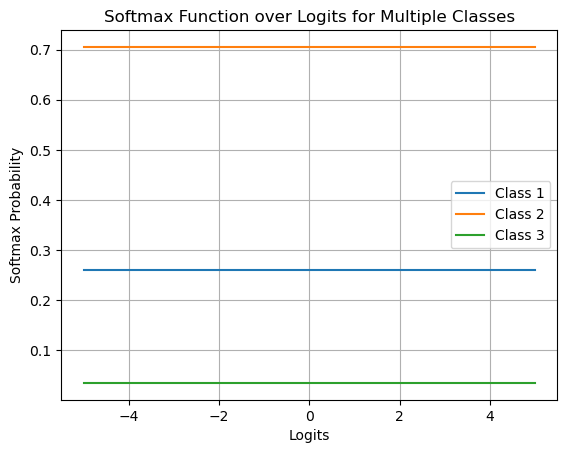

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def softmax(x):
    e_vals = np.exp(x - np.max(x))  # For numerical stability
    return e_vals / np.sum(e_vals)

# Create a range of logits for a 3-class system
logits = np.linspace(-5, 5, 100)

# Set the logits for each class
logits_for_classes = np.array([logits, logits + 1, logits - 2]).T

# Apply softmax function to the logits for each class
softmax_outputs = np.array([softmax(logit) for logit in logits_for_classes])

# Plot the output probabilities for each class
plt.plot(logits, softmax_outputs[:, 0], label="Class 1")
plt.plot(logits, softmax_outputs[:, 1], label="Class 2")
plt.plot(logits, softmax_outputs[:, 2], label="Class 3")

plt.xlabel("Logits")
plt.ylabel("Softmax Probability")
plt.title("Softmax Function over Logits for Multiple Classes")
plt.legend()
plt.grid(True)
plt.show()



### 7.4 Modifying the network, reworking data preprocess
The preprocess function_multi_class allows a more flexible approach and is ported above for testing on the BCE model

In [23]:
y# load MNIST from server and limit to 100 images per class since we are not running on a gpu
num_classes=5
limit = 200

x_train, y_train = preprocess_multiclass_data(x_train_dataset, y_train_dataset,limit, num_classes=num_classes)
x_test, y_test = preprocess_multiclass_data(x_test_dataset, y_test_dataset,limit, num_classes=num_classes)



(1000, 5) [0. 0. 1. 0. 0.]
(1000, 5, 1) [[0.]
 [0.]
 [1.]
 [0.]
 [0.]]
(1000, 5) [0. 0. 1. 0. 0.]
(1000, 5, 1) [[0.]
 [0.]
 [1.]
 [0.]
 [0.]]


In [24]:
# model from scratch specific imports
from dense import Dense
from relu  import ReLU
from convolutional import Convolutional
from reshape import Reshape
from activations import Tanh, Sigmoid
from losses import cross_entropy,cross_entropy_prime

In [66]:

# Create the modelV1 we are going for 5 classes
depth = 5
networkV1 = [
    Convolutional((1,28,28),kernel_size=3,depth=depth),
    Sigmoid(),
    Reshape(input_shape=(depth,26,26),
            output_shape=(depth*26*26,1)),  # column-wise Flattened
    Dense(input_size=(depth*26*26),output_size=200),
    Sigmoid(),
    Dense(200,5),
    Softmax()
]


In [67]:
total_loss_sum = []

In [68]:
from helper_functions import get_timer
# Training loop
epochs = 100
learning_rate = 0.01
loss_history= []
with get_timer() as timer:
    for epoch in range(epochs):
        error = 0    # optimizer.zero_grad
        for x,y in zip(x_train, y_train):  #for image in batch
            # forward pass
            output = x
            for layer in networkV1:
                output = layer.forward(output)
            #print (output)
    
            # calculate the loss
            error += cross_entropy(y_true=y, y_pred=output)
            
            # backward
            grad = cross_entropy_prime(y_true=y, y_pred=output)
            #print(grad)
            for layer in reversed(networkV1):
                grad = layer.backward(grad, learning_rate)
    
        error /= len(x_train)
        loss_history.append(error)
        if (epoch%10 == 0):
            print(f"Epoch: {epoch+1}/{epochs}, error = {error:.4f}")
total_train_time_model_1 = timer.elapsed_time

Epoch: 1/100, error = 5.7705
Epoch: 11/100, error = 0.4866
Epoch: 21/100, error = 0.2947
Epoch: 31/100, error = 0.2110
Epoch: 41/100, error = 0.1647
Epoch: 51/100, error = 0.1351
Epoch: 61/100, error = 0.1156
Epoch: 71/100, error = 0.0998
Epoch: 81/100, error = 0.0879
Epoch: 91/100, error = 0.0793
Elapsed time on None device: 294.3160 seconds


In [69]:
total_loss_sum
total_loss_sum.extend
(loss_history)
print(f"Total epochs run: {len(total_loss_sum)} ")

Total epochs run: 100 


In [70]:
for epoch in range(len(total_loss_sum)):
    if epoch%10 == 0:
        print(f"Epoch: {epoch+1}/{len(total_loss_sum)}, error = {total_loss_sum[epoch]:.4f}")

Epoch: 1/100, error = 5.7705
Epoch: 11/100, error = 0.4866
Epoch: 21/100, error = 0.2947
Epoch: 31/100, error = 0.2110
Epoch: 41/100, error = 0.1647
Epoch: 51/100, error = 0.1351
Epoch: 61/100, error = 0.1156
Epoch: 71/100, error = 0.0998
Epoch: 81/100, error = 0.0879
Epoch: 91/100, error = 0.0793


This is the current model running only 100 epochs with a dataset of 200 images per class

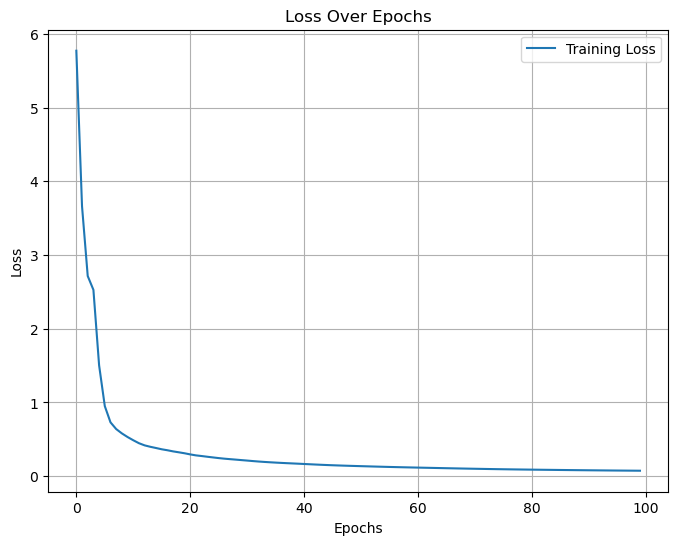

In [71]:
import matplotlib.pyplot as plt

def plot_loss(loss_history):
    plt.figure(figsize=(8, 6))
    plt.plot(loss_history, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(total_loss_sum)

In this model, the second layer was changed to a ReLU and its performance was marginal at 83% test accuracy

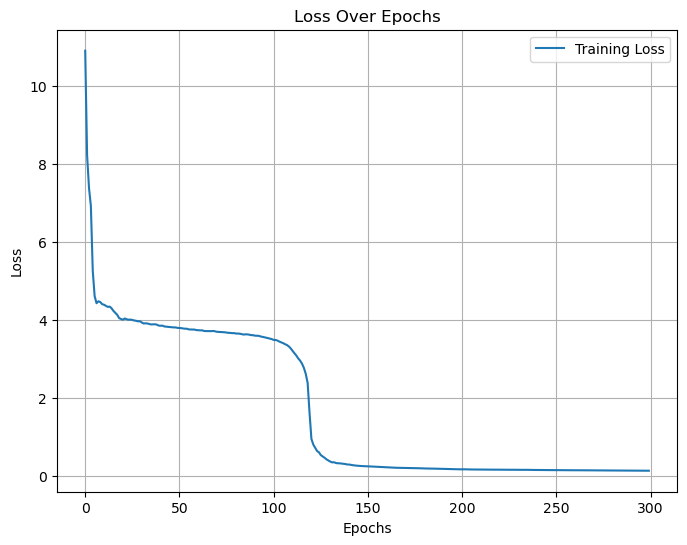

In [64]:
import matplotlib.pyplot as plt

def plot_loss(loss_history):
    plt.figure(figsize=(8, 6))
    plt.plot(loss_history, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(total_loss_sum)

In [75]:
# Test
test_logits = []
test_preds = []
test_labels = []
#i= 0
for x,y in zip(x_test, y_test):  #for image in batch
    # forward pass
    output = x
    for layer in networkV1:
        output = layer.forward(output)
    test_logits.append(output)
    test_preds.append(np.argmax(output))
    test_labels.append(np.argmax(y))
#    p, tag = test_logits[i], y_test[i]
#    print(f"probs; {(p[0].item()*100):.2f}%, {(p[1].item()*100):.2f}%,\t actual: {np.argmax(tag)}")
#    i+= 1
print(f"Accuracy = {accuracy_fn(test_preds, test_labels)}")

Accuracy = 91.5


In [ ]:
for p, pred, tag  in zip(test_logits,test_preds,test_labels):
    #p, tag = test_preds[i], y_test[i]
    if (pred==tag):
        print (f"probability for correct label {(p[tag].item()*100):.2f}%,  pred: {pred}, actual: {tag}")
    else:
        print (f"probability for incorrect label {(p[pred].item()*100):.2f}%,  pred: {pred}, actual: {tag}")
print("\n=================================")
print(f"Accuracy = {accuracy_fn(test_preds, test_labels)}")
print("=================================\n")
#    print(f"probs; {(p[0].item()*100):.2f}%, {(p[1].item()*100):.2f}%,\t actual: {np.argmax(tag)}")